In [9]:
%load_ext autoreload
%autoreload 2
from final_project.smlm_3d.data.visualise import scatter_3d, scatter_yz, show_psf_axial, plot_with_sphere, grid_psfs
from final_project.smlm_3d.data.datasets import GenericDataSet, ExperimentalDataSet, StormDataset, MultiImageStormDataset, TrainingDataSet

from final_project.smlm_3d.config.datasets import dataset_configs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# cfg['csv'] = cfg['csv'].replace('_filtered', '')
dataset = TrainingDataSet(dataset_configs['20220607_nanoruler_miguel']['training_20nm'], 
                          fit_plane_z=True, 
                          lazy=True, 
                          filter_emitters_proximity=False, 
                          transform_data=False, 
                          z_range=2000, 
                          add_noise=False, 
                          split_data=False, 
                          normalize_psf=True)
dataset.csv_data = dataset.csv_data[dataset.csv_data['sigma [nm]'] > 20]

# if 'detections' in dataset.csv_data:
#     dataset.csv_data = dataset.csv_data.sort_values('detections', ascending=False)
#     dataset.csv_data = dataset.csv_data[0:1]
# else:
#     dataset.csv_data = dataset.csv_data[10:11]

dataset.prepare_data()

# dataset_100nm = TrainingDataSet(dataset_configs['20220425_Miguel']['storm_slide'], 
#                           fit_plane_z=False, 
#                           lazy=True, 
#                           filter_emitters_proximity=False, 
#                           transform_data=False, 
#                           z_range=1000, 
#                           add_noise=False, 
#                           split_data=False, 
#                           normalize_psf=True)

# dataset = ExperimentalDataSet(cfg, normalize_psf=False, filter_localisations=False, lazy=True)
# dataset.backup_csv = dataset.csv_data.copy()
# dataset.prepare_data()

# dataset2 = StormDataset(dataset_configs['20220425_Miguel']['storm_slide'], lazy=True, normalize_psf=True)
# dataset2.prepare_data()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reading img...
Loading /home/miguel/Projects/uni/data/smlm_3d/20220607_nanoruler_miguel/20nm_bead_stacks/A3/stack_3um_20nm_1/stack_3um_20nm_1_MMStack_Default.ome.tif
Loading /home/miguel/Projects/uni/data/smlm_3d/20220607_nanoruler_miguel/20nm_bead_stacks/A3/stack_3um_20nm_1/stack_3um_20nm_1_MMStack_Default_filtered_filtered.csv
using image sharpness
29 emitters before filtering
29 emitters after borders
Failed to fit image gradient.
Failed to fit image gradient.
Failed to fit image gradient.
Failed to fit image gradient.
Failed to fit image gradient.
Failed to fit image gradient.
Failed to fit image gradient.
Failed to fit image gradient.
Failed to fit image gradient.



Rows 433 Cols 10 n_spaces 4330 n_psfs 4323


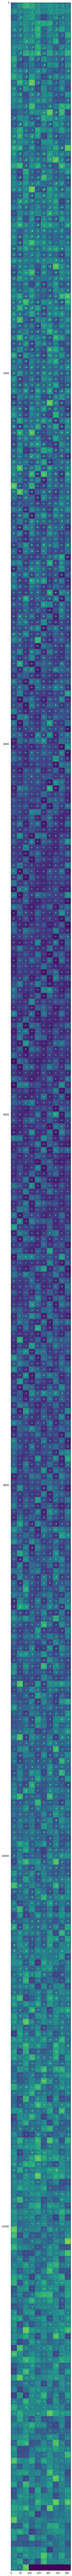

In [10]:
plt.rcParams['figure.figsize'] = [200, 200]
print()
imgs = dataset.data['all'][0][0][0:5000].squeeze()
ys = dataset.data['all'][1][0:5000].squeeze()
idx = np.argsort(ys)
imgs = imgs[idx]
plt.imshow(grid_psfs(imgs.squeeze()))
plt.show()




In [3]:
from skimage.filters import gaussian
from skimage.restoration import richardson_lucy


img = dataset.data['all'][0][0][50].squeeze()
print(img.shape)


voxel = np.zeros((img.shape))
voxel[15,15] = 1
voxel[16,16] = 1
voxel[17,17] = 1
voxel = gaussian(voxel, sigma=0.25)
voxel = voxel / voxel.max()
plt.imshow(voxel)
plt.show()

# voxel = np.ones((5,5)) / 25

restored = richardson_lucy(img, psf=voxel, num_iter=1)
plt.imshow(img)
plt.show()
plt.imshow(restored)
plt.show()






(32, 32)


KeyboardInterrupt: 

In [ ]:

def gather_dataset_info(data, name):
    records = []
    imgs, coords = data
    for img, coord in zip(imgs, coords):
        results = {
            'peak_brightness': img.max(),
            'min_brightness': img.min(),
            'mean_brightness': img.mean(),
            'median_brightness': np.median(img),
            'rho': coord[0],
            'theta': coord[1],
            'ds_name': name
        }
        records.append(results)

    df = pd.DataFrame.from_records(records)
    return df

dfs = pd.concat([
    gather_dataset_info(dataset.data['train'][0], '20nm_beads'),
    gather_dataset_info(dataset2.data, 'storm')
])


for col in list(dfs):
    if col == 'ds_name':
        continue
    dfs.boxplot(column=col, by='ds_name')
    plt.show()



In [ ]:
from final_project.smlm_3d.data.visualise import grid_psfs
import matplotlib.pyplot as plt


imgs = dataset.data['train'][0][0].squeeze()
img = grid_psfs(imgs[0:40])
plt.rcParams['figure.figsize'] = [300, 300]
plt.imshow(img)
plt.title('beads')
plt.show()

imgs = dataset2.data[0].squeeze()
img = grid_psfs(imgs[0:40])
plt.rcParams['figure.figsize'] = [300, 300]
plt.imshow(img)
plt.title('storm')
plt.show()



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from final_project.smlm_3d.config.datasets import dataset_configs

for config_name in dataset_configs:
    for dataset in dataset_configs[config_name]:
        cfg = dataset_configs[config_name][dataset]
        if '_filtered' in cfg['csv']:
            csv_path = str(cfg['bpath']) + '/' + cfg['csv']
            try:
                df_original = pd.read_csv(csv_path.replace('_filtered', ''))
                df_filtered = pd.read_csv(csv_path)
            except FileNotFoundError:
                continue
            print(config_name, dataset)
            df_original = pd.concat([df_original, df_filtered]).drop_duplicates(keep=False)
            df_original['kept'] = False
            df_filtered['kept'] = True

            df = pd.concat([df_original, df_filtered], ignore_index=True)
            for col in list(df):
                if col in ['id', 'frame', 'kept']:
                    continue
                sns.kdeplot(data=df, x=col, hue="kept", multiple="stack")
                plt.title(col)
                plt.show()